In [526]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import re
from matplotlib.markers import MarkerStyle
from matplotlib import gridspec

from scipy import integrate

In [487]:
DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")
DATA_DIR = os.path.join(os.path.dirname(DIRNAME), "FINO1Data")
ARRAY_PATH = os.path.join(DIRNAME, "Arrays")


os.makedirs(ARRAY_PATH, exist_ok=True)
os.makedirs(PLOTS_PATH, exist_ok=True)

p_list = [1,2,4,10]
ar_p_performances = []
for p in p_list:
    path = os.path.join(ARRAY_PATH, f"{p}", "AutoRegression2", f"AR({p})", "GustTh=1.5", "Beta=1")
    ar_p_performances.append({fname.replace(".dat", ""): pd.read_csv(os.path.join(path, fname), delimiter=" ", header=None, names=["TPR", "FPR"]) for fname in os.listdir(path) if fname.endswith(".dat")})

In [868]:
def plot_roc(*, dict_performances, train_pers):

    colors = sns.color_palette("rocket", len(dict_performances))
    fig = plt.figure(figsize=(30,40))
    gust_th = [1, 1.5, 2]
    model_type = ["a", "b", "c", "d"]
    
    gs = gridspec.GridSpec(4, 3, width_ratios=[1,1,1], height_ratios=[1,1,1,1], figure=fig, wspace=0.1, hspace=0.25)

    for i in range(4*3):
        sub_gs = gs[i].subgridspec(2,2, wspace=0.1, hspace=0.1, width_ratios=[1,1], height_ratios=[1,1])

        for j in range(4):
            ax0 = fig.add_subplot(sub_gs[j])
            ax0.set_title(f"({model_type[j % 4]})", fontsize=15)

            for idx, train_per in enumerate(train_pers):
                performance = dict_performances[train_per]
                plt.scatter(performance["FPR"], performance["TPR"], color=colors[idx], s=10,label=train_per)
                
            plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')
            plt.grid(linewidth=0.4, alpha=0.8)

            xticks = np.linspace(0,1,6)
            yticks = np.linspace(0,1,6)
            plt.xlim(0,1)
            plt.ylim(0,1)
            plt.minorticks_on()
            plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
            plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
            plt.xticks(xticks)
            plt.yticks(yticks)


            plt.xlabel("$FPR$", fontsize=10)
            plt.ylabel("$TPR$", fontsize=10)

        ax_abcd = fig.add_subplot(sub_gs[:])
        ax_abcd.axis('off')
        ax_abcd.set_title(f"$u_x={gust_th[i % 3]}$", fontsize=20)
    ax0.legend(title=r"Training period $\tau$ $[s]$", fontsize=20)
            



    #plt.savefig(os.path.join(PLOTS_PATH, "test2.png"), format="png", dpi=300, bbox_inches="tight")

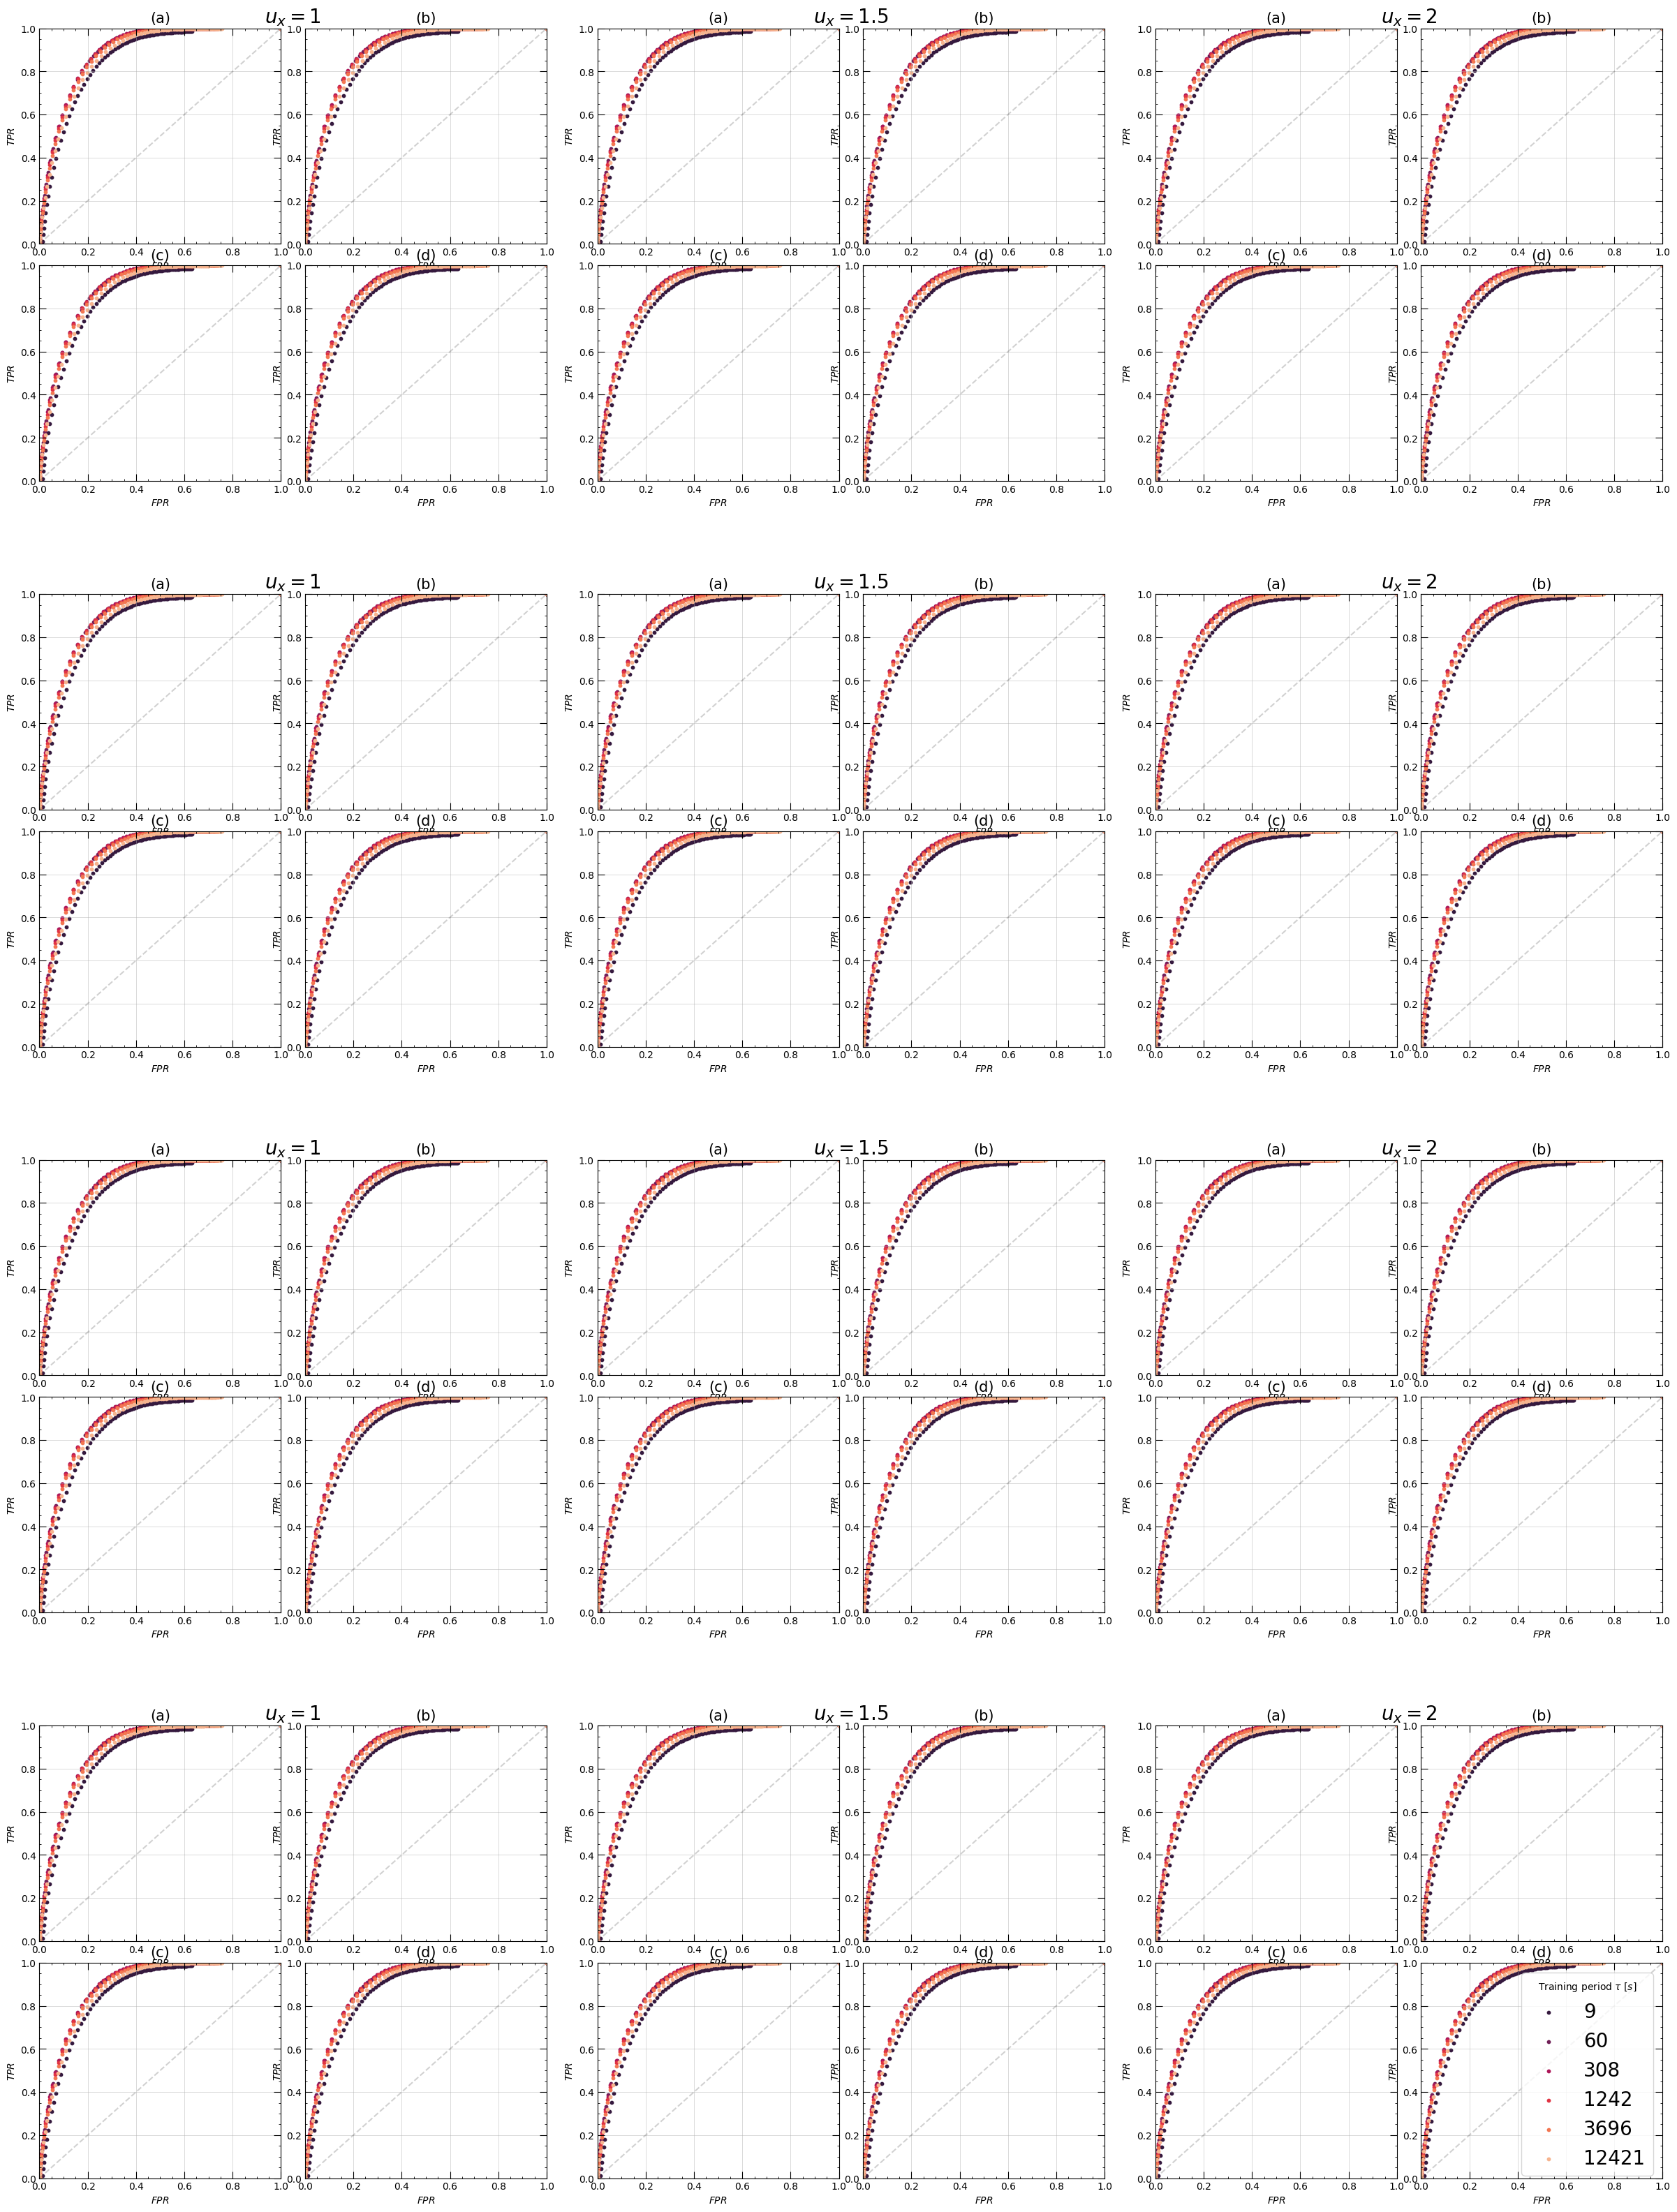

In [869]:
train_pers = [9, 60, 308, 1242, 3696, 12421]
dict_performances = dict.fromkeys(train_pers)

for performances in ar_p_performances[1:2]:
    for fname, performance in performances.items():
        train_per_match = re.search(r"training_per=([\d.]+)", fname)
        train_per = train_per_match.group(1) if train_per_match else None

        if int(train_per) in train_pers:
            dict_performances[int(train_per)] = performance

    plot_roc(dict_performances=dict_performances, train_pers=train_pers)

In [839]:
def get_auc(performance):
    integy = np.flip(performance["TPR"])
    integx = np.flip(performance["FPR"])
    return integrate.trapezoid(y=integy, x=integx)

def get_xi_opt(performance):
    return max(abs(performance["TPR"] - performance["FPR"]) / 2**0.5)

In [840]:
p_aucs = []
p_xis = []

for performances in ar_p_performances:
    train_pers = {}
    train_pers2 = {}
    for fname, performance in performances.items():
        
        auc = get_auc(performance)
        xi_opt = get_xi_opt(performance)
        train_per_match = re.search(r"training_per=([\d.]+)", fname)
        train_per = train_per_match.group(1) if train_per_match else None
        
        train_pers[int(train_per)] = auc
        train_pers2[int(train_per)] = xi_opt

            
    p_aucs.append(train_pers)
    p_xis.append(train_pers2)

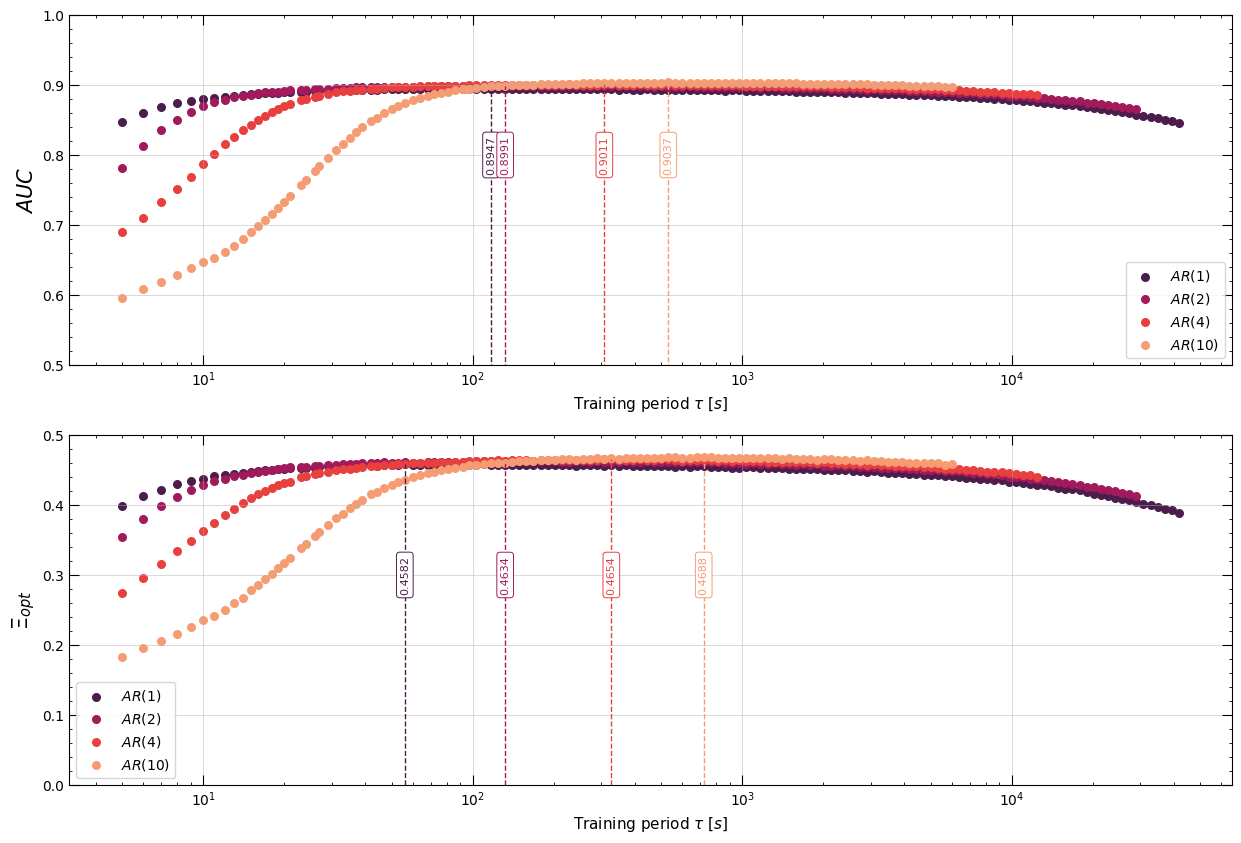

In [853]:
def plot2(*, p_scores):
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(15,10))

    colors = sns.color_palette("rocket", len(p_scores[0]))

    for j, train_pers in enumerate(p_scores[0]):

        #auc_th = list(filter(lambda x: (train_pers[x]>0.9), train_pers.keys()))
        max_key = max(train_pers, key=train_pers.get)

        ax0.vlines(max_key,linestyles="--", ymin=0, ymax=train_pers[max_key], linewidth=1, color=colors[j], alpha=1)
        ax0.annotate(f"{train_pers[max_key]:.4f}", xy=(max_key, 0.8), rotation=90, 
                    va="center", ha="center", fontsize=8,
                    bbox=dict(boxstyle="round", fc="w", linewidth=0.7, color=colors[j]), alpha=1, color=colors[j])
        
        ax0.scatter(train_pers.keys(), train_pers.values(), marker=MarkerStyle('o', fillstyle='full'), s=30, color=colors[j], label=f"$AR({p_list[j]})$")
        ax0.set_xlabel(r"Training period $\tau$ $[s]$", fontsize=11)
        ax0.set_ylabel(r"$AUC$", fontsize=15)
        ax0.set_xscale("log")
        ax0.set_ylim(0.5, 1)

        ax0.grid(linewidth=0.4, alpha=0.8)

        ax0.legend()

        ax0.minorticks_on()
        ax0.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
        ax0.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)


    for j, train_pers in enumerate(p_scores[1]):

        #auc_th = list(filter(lambda x: (train_pers[x]>0.9), train_pers.keys()))
        max_key = max(train_pers, key=train_pers.get)

        ax1.vlines(max_key,linestyles="--", ymin=0, ymax=train_pers[max_key], linewidth=1, color=colors[j], alpha=1)
        ax1.annotate(f"{train_pers[max_key]:.4f}", xy=(max_key, 0.3), rotation=90, 
                    va="center", ha="center", fontsize=8,
                    bbox=dict(boxstyle="round", fc="w", linewidth=0.7, color=colors[j]), alpha=1, color=colors[j])
        
        ax1.scatter(train_pers.keys(), train_pers.values(), marker=MarkerStyle('o', fillstyle='full'), s=30, color=colors[j], label=f"$AR({p_list[j]})$")


        ax1.set_xlabel(r"Training period $\tau$ $[s]$", fontsize=11)
        ax1.set_ylabel(r"$\Xi_{opt}$", fontsize=15)
        ax1.set_xscale("log")
        ax1.set_ylim(0, 0.5)

        ax1.grid(linewidth=0.4, alpha=0.8)

        ax1.legend()

        ax1.minorticks_on()
        ax1.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
        ax1.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
    plt.savefig(os.path.join(PLOTS_PATH, "scors.png"))

plot2(p_scores=[p_aucs, p_xis])